In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm, transforms
import geopandas as gpd
import locale
from scipy import stats
from statsmodels.formula.api import ols
from svgpathtools import svg2paths
from svgpath2mpl import parse_path

locale.setlocale(locale.LC_ALL, 'es_CL')

plt.style.use("seaborn")
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.grid'] = False
sns.set(font_scale=1.5)

BASE = "/media/giani/Gianicosas/Magister/Proyecto/"

# Datos

In [2]:
df = pd.read_csv(f"{BASE}work_data/matriz_desercion_1.csv.gz")
df.head(2)

/tmp/ipykernel_37694/3290675988.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{BASE}work_data/matriz_desercion_1.csv.gz")


,cat_periodo,codigo_unico,mrun,gen_alu,fec_nac_alu,anio_ing_carr_ori,tipo_inst_1,region_sede,area_conocimiento,desertor_1,region_colegio,tipo_ensenanza_colegio,prom_notas_media,dependencia_colegio
0,2015,I498S6C132J2V1,37.0,1,197808,2015,Centros de Formación Técnica,Biobío,Tecnología,0.0,NaN,NaN,NaN,NaN
1,2015,I111S14C309J2V1,118.0,1,199102,2015,Institutos Profesionales,Metropolitana,Administración y Comercio,0.0,13,310.0,4.975,3.0


# Deserción

In [3]:
df["anio_desercion"] = df["cat_periodo"] + 1

In [4]:
porc_des = pd.DataFrame(df.groupby(["anio_desercion"])["desertor_1"].value_counts("%").rename("%") * 100).reset_index()
porc_des = porc_des[porc_des["desertor_1"]==1]
porc_des

,anio_desercion,desertor_1,%
1,2016,1.0,16.382254
3,2017,1.0,14.418847
5,2018,1.0,13.360973
7,2019,1.0,13.062208
9,2020,1.0,15.068913
11,2021,1.0,16.939409
13,2022,1.0,24.696973


# Region de institución

In [5]:
df["region_sede"].unique()

array(['Biobío', 'Metropolitana', 'Coquimbo', 'Antofagasta', 'Valparaíso',
       'Los Lagos', "Lib. Gral B. O'Higgins", 'Arica y Parinacota',
       'La Araucanía', 'Atacama', 'Los Ríos', 'Maule', 'Ñuble',
       'Magallanes', 'Tarapacá', 'Aysén'], dtype=object)

In [6]:
order_reg = [
    'Arica y Parinacota','Tarapacá','Antofagasta','Atacama',
    'Coquimbo','Valparaíso','Metropolitana',"Lib. Gral B. O'Higgins",
    'Maule', 'Ñuble', 'Biobío','La Araucanía', 'Los Ríos',
    'Los Lagos', 'Aysén', 'Magallanes'
]

assert len(order_reg) == df["region_sede"].nunique()

## Mapas Geo

In [7]:
# Scar del link del readme
regiones = gpd.read_file('regiones.geojson').to_crs(epsg=4326)
regiones.head()

,objectid,cir_sena,codregion,area_km,st_area_sh,st_length_,Region,geometry
0,1084,1,15,16866.819844,1.886869e+10,7.505296e+05,Región de Arica y Parinacota,"POLYGON ((-69.41531 -17.65521, -69.40802 -17.6..."
1,1085,2,1,42284.567484,4.830637e+10,1.213713e+06,Región de Tarapacá,"MULTIPOLYGON (((-70.16034 -20.21070, -70.16031..."
2,1086,3,2,126071.431981,1.508452e+11,2.516112e+06,Región de Antofagasta,"MULTIPOLYGON (((-70.70164 -25.89174, -70.70130..."
3,1087,15,12,133053.142345,3.581316e+11,9.049830e+07,Región de Magallanes y Antártica Chilena,"MULTIPOLYGON (((-67.32026 -55.92015, -67.31971..."
4,1088,14,11,106703.377369,2.242743e+11,4.144481e+07,Región de Aysén del Gral.Ibañez del Campo,"MULTIPOLYGON (((-75.57992 -48.75893, -75.58028..."


In [8]:
regiones.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
regiones["Region"] = regiones["Region"].replace(
    sorted(regiones["Region"].unique())[:-1],
    [
        "Metropolitana", "Antofagasta", "Arica y Parinacota", "Atacama", "Aysén", "Coquimbo", "La Araucanía", "Los Lagos", "Los Ríos",
        "Magallanes", "Tarapacá", "Valparaíso", "Ñuble", "Biobío", "Lib. Gral B. O'Higgins", "Maule"
    ]
)

In [10]:
cantidades = df[df["anio_desercion"] < 2021][
    ["anio_desercion", "mrun", "desertor_1", "region_sede"]
].drop_duplicates().rename(columns={
    "region_sede": "Region"
}).groupby(["anio_desercion", "Region"]).agg({
    "mrun": pd.Series.nunique,
    "desertor_1": "sum"
}).reset_index()#.groupby(["Region"]).agg({"mrun": "mean","desertor_1": "mean"}).reset_index().round()

cantidades.head()

,anio_desercion,Region,mrun,desertor_1
0,2016,Antofagasta,5505,927.0
1,2016,Arica y Parinacota,2431,389.0
2,2016,Atacama,1884,345.0
3,2016,Aysén,570,96.0
4,2016,Biobío,18087,2726.0


In [11]:
cantidades["desertor_1_porc"] = [
    (d / cantidades[
        (cantidades["anio_desercion"] == a)
        & (cantidades["Region"] == r)
    ]["mrun"].sum()) * 100 
    for a, d, r in zip(cantidades["anio_desercion"], cantidades["desertor_1"], cantidades["Region"])
]

cantidades.head()

,anio_desercion,Region,mrun,desertor_1,desertor_1_porc
0,2016,Antofagasta,5505,927.0,16.839237
1,2016,Arica y Parinacota,2431,389.0,16.001645
2,2016,Atacama,1884,345.0,18.312102
3,2016,Aysén,570,96.0,16.842105
4,2016,Biobío,18087,2726.0,15.071598


In [12]:
regiones_mat_des = gpd.GeoDataFrame(pd.merge(
    cantidades,
    regiones[["Region", "geometry"]],
    how="left"
))

In [13]:
regiones_mat_des["centro"] = regiones_mat_des["geometry"].centroid.to_crs(4326)
centros = regiones_mat_des[["centro", "Region"]].drop_duplicates().set_geometry("centro")

/tmp/ipykernel_37694/363712993.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  regiones_mat_des["centro"] = regiones_mat_des["geometry"].centroid.to_crs(4326)


In [58]:
# # create the colorbar
norm = colors.Normalize(vmin=cantidades["desertor_1_porc"].min(), vmax=cantidades["desertor_1_porc"].max())
colores = cm.get_cmap('coolwarm', 256)
cbar = plt.cm.ScalarMappable(norm=norm, cmap=colores)

/tmp/ipykernel_37694/2788143234.py:57: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax_cbar = fig.colorbar(


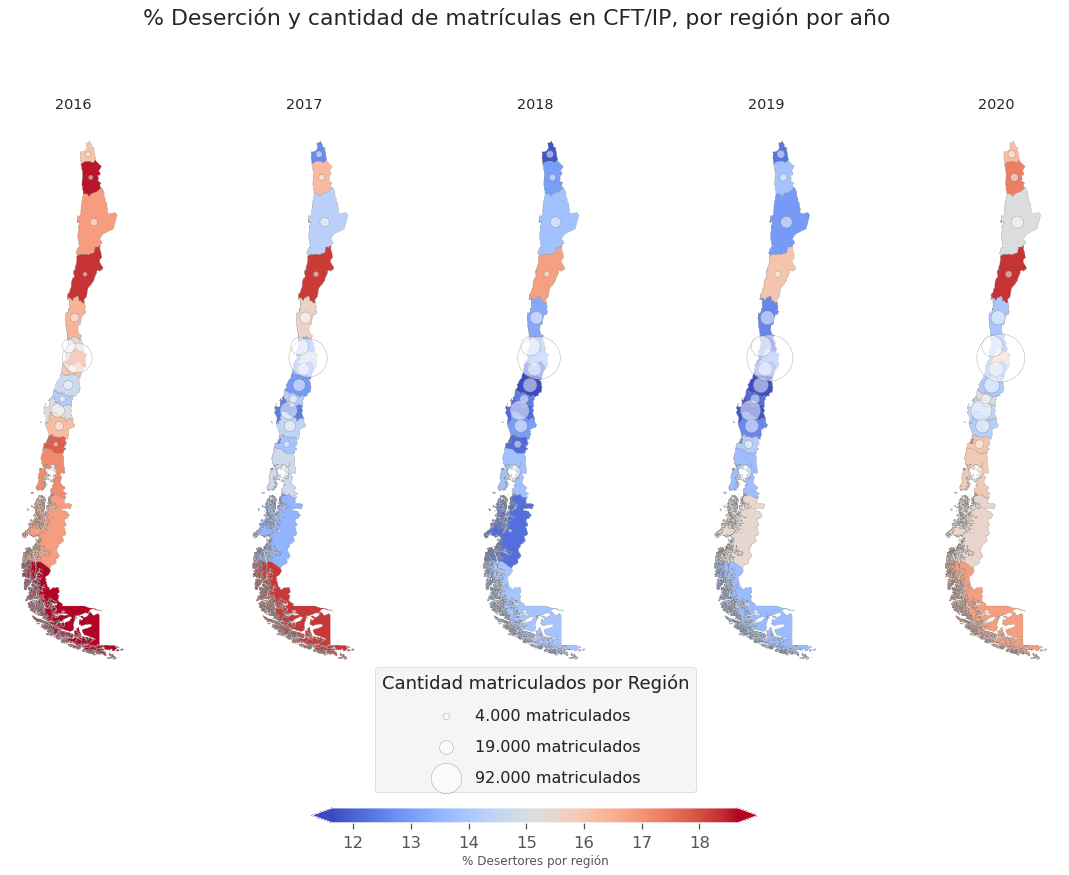

In [59]:
# plot
anios = sorted(regiones_mat_des["anio_desercion"].unique())
fig, axes = plt.subplots(figsize=(20,15), ncols=len(anios), nrows=1);
axes = axes.flatten()
plt.suptitle("% Deserción y cantidad de matrículas en CFT/IP, por región por año", fontsize=22)

for i, a in enumerate(anios):
    t = regiones_mat_des[
        (regiones_mat_des["anio_desercion"]==a)
    ].copy()

    base = t.plot(
        ax=axes[i],
        column="desertor_1_porc",
        #legend=True,
        linewidth=0.2,
        cmap=colores,
        norm=norm,
        edgecolor="grey"
    );
    centros.plot(
        ax=base,
        marker="o",
        color="white",
        edgecolor="dimgrey",
        markersize=t["mrun"] / 100,
        alpha=0.5,
        legend=True
    );
    axes[i].set_xlim([-77, -65]);
    axes[i].set_title(a);
    axes[i].set_axis_off();
    axes[i].grid(None);
    
    if i == len(axes) - 1:        
        # Adds three phantom data points to the map, plotted off-screen at lat=lon=0
        for area in (cantidades["mrun"]).quantile([.25, .75, .95]):
            axes[i].scatter(
                [0], [0], c='white',
                alpha=0.5, s=area / 100,
                edgecolor="dimgrey",
                label=f'{locale.format_string("%.f", int(np.round(area, -3)), grouping=True)} matriculados'
            )

        # Creates the legend with black circles
        legend1 = axes[i].legend(
            scatterpoints=1, frameon=True, labelspacing=1, loc='lower center', fontsize=16, 
            bbox_to_anchor=(-3, -0.2),
            title="Cantidad matriculados por Región",
            title_fontsize=18
        )

        # Adds the legend above to the current axes in the figure
        fig.gca().add_artist(legend1)

# add colorbar
ax_cbar = fig.colorbar(
    cbar, ax=axes, location="bottom", orientation="horizontal",
    aspect=30, shrink=0.4, extend='both'
)
ax_cbar.set_label('% Desertores por región')
#ax_cbar.set_yticklabels(['{0:.2f}%'.format(ytick*100) for ytick in yticks])

In [16]:
regiones_ord_geo = [
    'Arica y Parinacota', 'Tarapacá', 'Antofagasta', 'Atacama', 'Coquimbo', 'Valparaíso',
    'Metropolitana', "Lib. Gral B. O'Higgins", 'Maule', 'Ñuble', 'Biobío', 'La Araucanía',
    'Los Ríos', 'Los Lagos', 'Aysén', 'Magallanes'
]

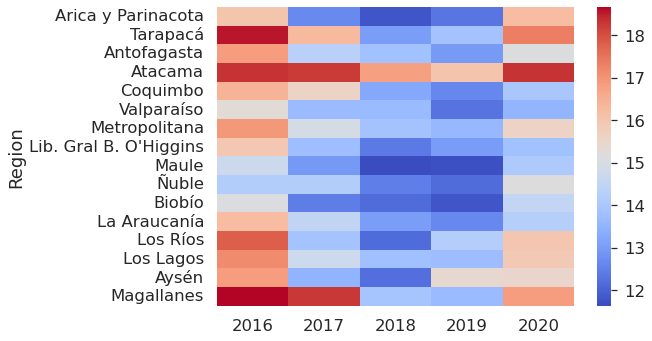

In [17]:
t = cantidades[["anio_desercion", "Region", "desertor_1_porc"]]
piv = pd.pivot_table(
    t, values="desertor_1_porc", index=["anio_desercion"], columns=["Region"]
).reset_index().T
piv = piv.rename(columns=piv.iloc[0].astype(int))[1:].reindex(index=regiones_ord_geo)
sns.heatmap(piv, cmap="coolwarm");

In [18]:
melted = pd.melt(piv.T, value_vars=regiones_ord_geo)
model = ols('value ~ C(Region)', data=melted).fit()
resumen = model.summary2()
resumen.tables[0]

,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.228
1,Dependent Variable:,value,AIC:,322.6230
2,Date:,2022-10-05 21:11,BIC:,360.7354
3,No. Observations:,80,Log-Likelihood:,-145.31
4,Df Model:,15,F-statistic:,2.552
5,Df Residuals:,64,Prob (F-statistic):,0.00489
6,R-squared:,0.374,Scale:,2.7678


In [19]:
coefs = resumen.tables[1]
coefs[coefs["P>|t|"] < 0.05]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,14.606271,0.744017,19.631645,8.767653e-29,13.119927,16.092615
C(Region)[T.Atacama],2.929680,1.052198,2.784342,7.045282e-03,0.827672,5.031688


# Area del conocimiento

In [20]:
df["area_conocimiento"].unique()

array(['Tecnología', 'Administración y Comercio', 'Salud', 'Educación',
       'Ciencias Sociales', 'Arte y Arquitectura', 'Agropecuaria',
       'Ciencias Básicas', 'Derecho', 'Humanidades'], dtype=object)

In [21]:
cantidades_conoc = df[df["anio_desercion"] < 2021][
    ["anio_desercion", "mrun", "desertor_1", "area_conocimiento"]
].drop_duplicates().groupby([
    "anio_desercion", "area_conocimiento"
]).agg({
    "mrun": pd.Series.nunique,
    "desertor_1": "sum"
}).reset_index()

cantidades_conoc["desertor_1_porc"] = [
    (d / cantidades_conoc[
        (cantidades_conoc["anio_desercion"] == a)
        & (cantidades_conoc["area_conocimiento"] == r)
    ]["mrun"].sum()) * 100 
    for a, d, r in zip(cantidades_conoc["anio_desercion"], cantidades_conoc["desertor_1"], cantidades_conoc["area_conocimiento"])
]

cantidades_conoc.head()

,anio_desercion,area_conocimiento,mrun,desertor_1,desertor_1_porc
0,2016,Administración y Comercio,48809,7427.0,15.216456
1,2016,Agropecuaria,2973,480.0,16.145308
2,2016,Arte y Arquitectura,8837,1357.0,15.355890
3,2016,Ciencias Básicas,1062,138.0,12.994350
4,2016,Ciencias Sociales,8564,1459.0,17.036432


In [47]:
diccionario_iconos = {
    'Tecnología': "microchip-solid.svg",
    'Administración y Comercio': "money-bill-1-solid.svg",
    'Salud': "suitcase-medical-solid.svg",
    'Educación': "book-open-reader-solid.svg",
    'Ciencias Sociales': "users-solid.svg",
    'Arte y Arquitectura': "compass-drafting-solid.svg",
    'Agropecuaria': "wheat-awn-solid.svg",
    'Ciencias Básicas': "flask-solid.svg",
    'Derecho': "scale-balanced-solid.svg",
    'Humanidades': "feather-solid.svg"
}

In [79]:
colores_area = [
    "#4E79A7", "#F18E2C", "#E15759", "#76B7B2", "#59A14E", "#EDC949", "#B07AA2", "#EF9BA6", "#9C755F", "#BAB0AC"
]

y_ticks_vals = np.arange(8, 21, 2, dtype=int)

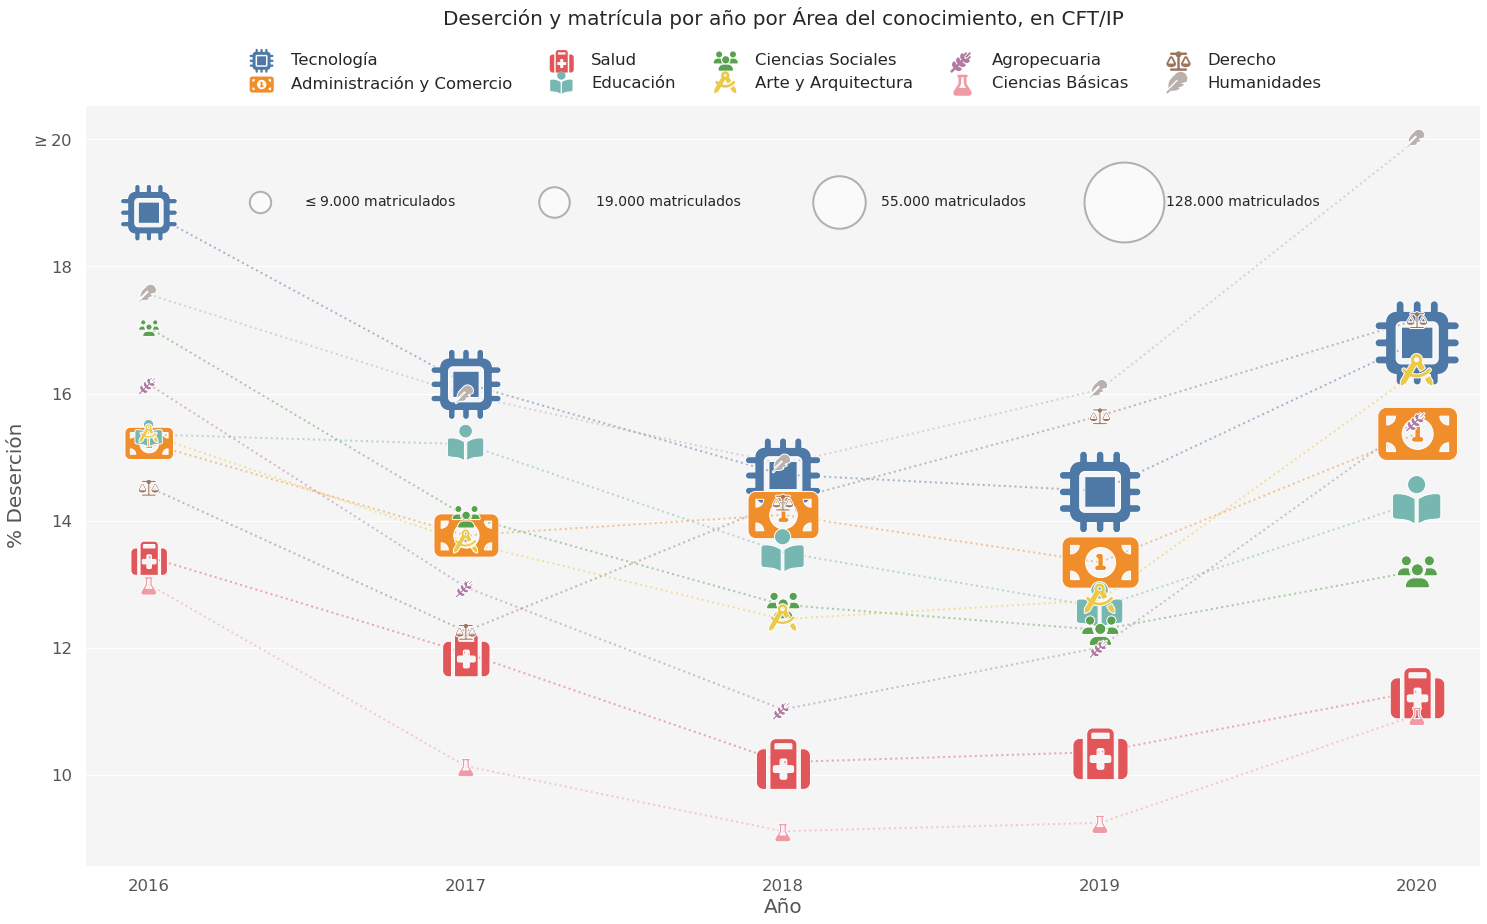

In [81]:
fig = plt.figure(figsize=(25, 14))
plt.style.use("ggplot")
plt.rcParams['axes.facecolor']='whitesmoke'

for i, area in enumerate(df["area_conocimiento"].unique()):
    icon_path, attributes = svg2paths(f'icons/{diccionario_iconos[area]}')
    icon_marker = parse_path(attributes[0]['d'])
    icon_marker.vertices -= icon_marker.vertices.mean(axis=0)
    icon_marker = icon_marker.transformed(transforms.Affine2D().rotate_deg(180))
    icon_marker = icon_marker.transformed(transforms.Affine2D().scale(-1,1))

    tmp_df = cantidades_conoc[cantidades_conoc["area_conocimiento"]==area]

    y = "desertor_1_porc"
    x = "anio_desercion"
    y_vals = tmp_df[y].copy()
    y_vals = np.where(y_vals > 20, 20, y_vals)
    
    sizes = tmp_df["mrun"] / 20
    corte = np.round(cantidades_conoc["mrun"].quantile(.4), -3) / 20
    sizes = np.where(sizes < corte, corte, sizes)
    
    plt.plot(tmp_df[x], y_vals, ls="dotted", lw=2, alpha=0.5, color=colores_area[i])
    plt.scatter(tmp_df[x], y_vals, sizes, marker=icon_marker, label=area, lw=1, zorder=3, edgecolor="white", color=colores_area[i]);
    plt.xticks(tmp_df[x]);
    plt.yticks(y_ticks_vals, [r"$\geq 20$" if j == 20 else j for j in y_ticks_vals]);
    
plt.xlabel("Año", fontsize=20);
plt.ylabel("% Deserción", fontsize=20)
    
plt.title("Deserción y matrícula por año por Área del conocimiento, en CFT/IP", pad=80, fontsize=20)
#plt.ylim(8.5, 20)
plt.gca().xaxis.grid(False)
lgnd = plt.legend(ncol=5, bbox_to_anchor=(0.5,1.09), loc="upper center");

#change the marker size manually for both lines
for l in lgnd.legendHandles:
    l.set_sizes([400])
    l.set_linewidth(0)
   
plt.gca().add_artist(lgnd);

#change the marker size manually for both lines
for l in lgnd.legendHandles:
    l.set_sizes([600])
    l.set_linewidth(0)
    
# Segunda leyenda
for i, area in enumerate((cantidades_conoc["mrun"]).quantile([.4, .50, .75, .95])):
    aux = r'$\leq$' if i == 0 else ""
    plt.scatter(
        [0], [0], c='white',
        alpha=0.5, s=area / 20,
        edgecolor="dimgrey",
        lw=2,
        label=f'{aux}{locale.format_string("%.f", int(np.round(area, -3)), grouping=True)} matriculados'
    ) 
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = {l: v for l, v in zip(labels, handles) if l not in df["area_conocimiento"].unique()}
plt.legend(by_label.values(), by_label.keys(), ncol=4, bbox_to_anchor=(0.5,0.9), loc="upper center", fontsize=14, handletextpad=2, columnspacing=6);

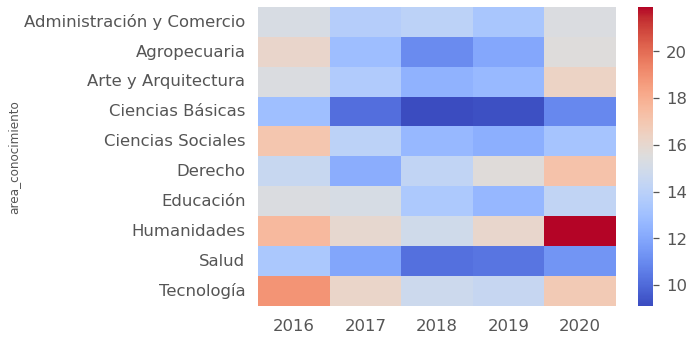

In [52]:
t2 = cantidades_conoc[["anio_desercion", "area_conocimiento", "desertor_1_porc"]]
piv2 = pd.pivot_table(
    t2, values="desertor_1_porc", index=["anio_desercion"], columns=["area_conocimiento"]
).reset_index().T
piv2 = piv2.rename(columns=piv2.iloc[0].astype(int))[1:]
sns.heatmap(piv2, cmap="coolwarm");

In [53]:
melted2 = pd.melt(piv2.T, value_vars=cantidades_conoc["area_conocimiento"].unique())
model2 = ols('value ~ C(area_conocimiento)', data=melted2).fit()
resumen2 = model2.summary2()
resumen2.tables[0]

,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.488
1,Dependent Variable:,value,AIC:,208.6039
2,Date:,2022-10-05 21:41,BIC:,227.7242
3,No. Observations:,50,Log-Likelihood:,-94.302
4,Df Model:,9,F-statistic:,6.200
5,Df Residuals:,40,Prob (F-statistic):,1.97e-05
6,R-squared:,0.582,Scale:,3.1815


In [55]:
coefs2 = resumen2.tables[1]
coefs2[coefs2["P>|t|"] < 0.05]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
Intercept,14.357348,0.797681,17.998859,8.757127e-21,12.745175,15.969522
C(area_conocimiento)[T.Ciencias Básicas],-3.872072,1.128091,-3.432410,1.403944e-03,-6.152030,-1.592115
C(area_conocimiento)[T.Humanidades],2.919470,1.128091,2.587973,1.339167e-02,0.639513,5.199428
C(area_conocimiento)[T.Salud],-2.915474,1.128091,-2.584431,1.350970e-02,-5.195432,-0.635516
